# Let's figure out how to cluster to find representative motifs, part 2

Let's try this again, but using multiple species of data to see if there's something we can actually distinguish in euclidean space.

In [8]:
from pathlib import Path
import numpy as np
import IPython.display as ipd
import librosa


def cens_per_sec(sample_rate, target):
    """Ensure this value is a multiple of 2**6"""
    return (sample_rate // (target * (2 ** 6))) * (2 ** 6)

def chroma_cens(data, sample_rate=22050, cens_sr=10):
    return librosa.feature.chroma_cens(
        data, sample_rate, hop_length=cens_per_sec(sample_rate, cens_sr)
    )

def normalize(row):
    if row.shape[0] == 600:
        return row
    if row.shape[0] > 600:
        return row[:600]
    if row.shape[0] < 600:
        return np.append(row, np.zeros(600-row.shape[0]))

    
root = Path("../data")
motif = root / "motif/train_short_audio"

data = []
audio = []
for path in motif.glob("**/*.npy"):
    data.append(np.load(path))
    audio.append((path.parent.parent.name, path.as_posix().replace(".npy", ".ogg")))
data[:3], audio[:3]

([array([-0.03904096, -0.00558044,  0.04428169, ...,  0.00819153,
         -0.06710614,  0.10478839], dtype=float32),
  array([-0.01430092, -0.0170906 ,  0.10328198, ...,  0.01795918,
         -0.08808021, -0.01743562], dtype=float32),
  array([-0.13549505, -0.20519714,  0.05989559, ...,  0.11850143,
          0.05523453, -0.00157669], dtype=float32)],
 [('acafly', '../data/motif/train_short_audio/acafly/XC109605/motif.0.ogg'),
  ('acafly', '../data/motif/train_short_audio/acafly/XC109605/motif.1.ogg'),
  ('acafly', '../data/motif/train_short_audio/acafly/XC11209/motif.0.ogg')])

In [9]:
chroma = [chroma_cens(row).reshape(-1) for row in data]
X = np.stack([normalize(r) for r in chroma])

In [10]:
X.shape

(592, 600)

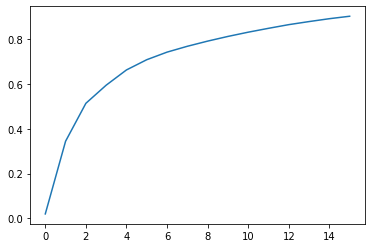

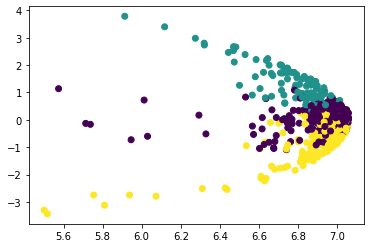

array([[102,  44, 402, 509, 103],
       [ 93, 167, 170, 154, 166],
       [353, 448, 246,  84, 191]], dtype=int64)

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors

svd = TruncatedSVD(n_components=16)
svd.fit(X)
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.show()

g = svd.transform(X)

kmeans = KMeans(n_clusters=3)
km = kmeans.fit(g)

plt.scatter(g[:, 0], g[:, 1], c=km.labels_)
plt.show()

nn = NearestNeighbors().fit(g)
dist, neighbors = nn.kneighbors(km.cluster_centers_)
neighbors

In [22]:
from sklearn import preprocessing
species = [sp for sp, _ in audio]
le = preprocessing.LabelEncoder()
le.fit(species)
le.classes_

array(['acafly', 'acowoo', 'osprey'], dtype='<U6')

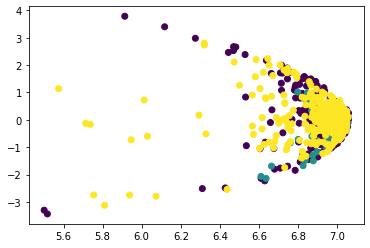

In [23]:
plt.scatter(g[:, 0], g[:, 1], c=le.transform(species))
plt.show()

nn for label 0
 for acafly


 for acafly


 for osprey


 for osprey


 for acafly


nn for label 1
 for acafly


 for acafly


 for acafly


 for acafly


 for acafly


nn for label 2
 for osprey


 for osprey


 for acafly


 for acafly


 for acafly


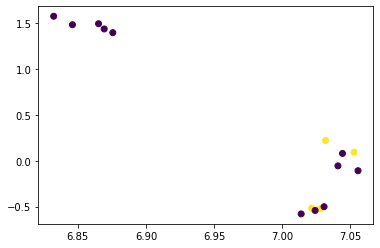

In [25]:
nn_g = g[neighbors.reshape(-1)]
plt.scatter(nn_g[:, 0], nn_g[:, 1], c=le.transform(species)[neighbors.reshape(-1)])

for label, group in enumerate(neighbors):
    print(f"nn for label {label}")
    for i in group:
        sp, path = audio[i]
        print(f" for {sp}")
        ipd.display(ipd.Audio(path))

## single class, spectral embedding on the knn graph
Let's try this again, but use a different embedding.

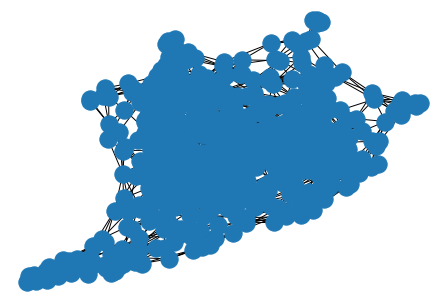

In [26]:
import networkx as nx

G = nx.from_scipy_sparse_matrix(nn.kneighbors_graph())
nx.draw(G)

In [27]:
from sklearn.manifold import spectral_embedding

emb = spectral_embedding(nn.kneighbors_graph())

c:\kaggle\birdclef-2021\venv\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


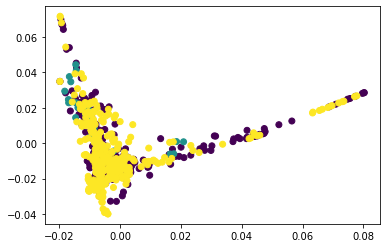

In [29]:
plt.scatter(emb[:, 0], emb[:, 1], c=le.transform(species))

So this one ends up a failure too, huh. Let's try a little learning next...